In [1]:
from audiofile import AudioFile

# 1. Spectrogram analysis

The nylon guitar tone:
- Is composed of harmonic sine waves with decaying amplitude
- Has additional energy in the frequency band below the fundamental frequency (this is more visible in section 2. Filter analysis). These lower frequencies don't have any harmonics themselves.

The grand piano tone:
- Is composed of harmonic sine waves, as well as many powerful non-harmonic frequencies
- Has more energy around the 3rd and 4th harmonics than the fundamental (this is more visible in section 2. Filter analysis). These higher frequencies don't have any harmonics themselves.

In [2]:
guitar = AudioFile('test', 'guitar_acoustic', 6)
piano = AudioFile('train', 'keyboard_acoustic', 27)
guitar.fundamental_freq = 110  # A2
piano.fundamental_freq = 55  # A1

## Guitar

--------------
Guitar attack:
--------------


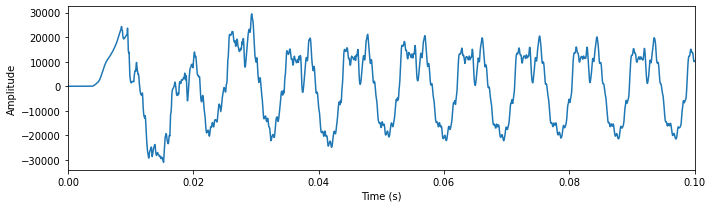

- original sound:


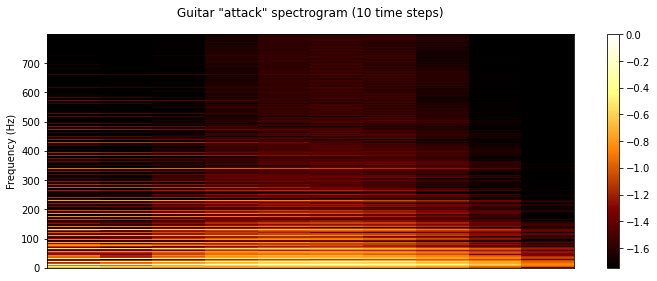

- reconstructed sound:


---------------
Guitar sustain:
---------------


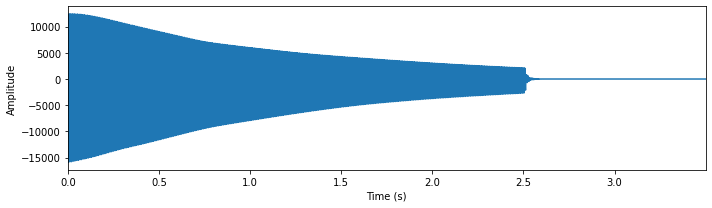

- original sound:


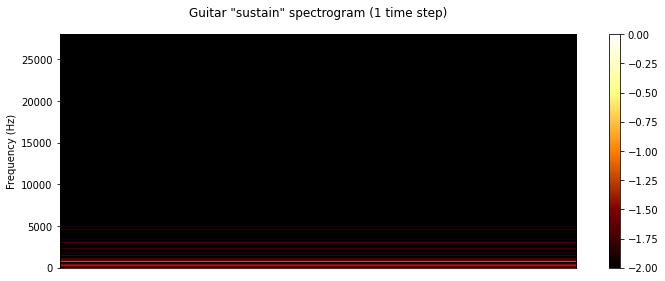

- reconstructed sound:


In [3]:
# Guitar
params = [
    {'start': 0, 'end': 0.1, 'time_intervals': 10, 'spec_thresh': 3.5, 'max_freq': -1,
     'print': 'Guitar attack:', 'title': 'Guitar "attack" spectrogram (10 time steps)'},
    {'start': 0.5, 'end': -1, 'time_intervals': 1, 'spec_thresh': 4, 'max_freq': -1,
     'print': 'Guitar sustain:', 'title': 'Guitar "sustain" spectrogram (1 time step)'}
]
for p in params:
    # Print
    print('-' * len(p['print']))
    print(p['print'])
    print('-' * len(p['print']))
    # Load and play audio
    guitar.load_audio(p['start'], p['end'])
    guitar.plot_audio()
    print('- original sound:')
    guitar.play_audio()
    # Create spectrogram and reconstruct audio
    guitar.audio_to_spectrogram(p['time_intervals'], p['spec_thresh'])
    guitar.plot_spectrogram(guitar.spectrogram/2, max_freq=p['max_freq'],
                            title=p['title'], figsize=(10, 4))
    print('- reconstructed sound:')
    guitar.spectrogram_to_audio(guitar.spectrogram)

# Convolve spectrogram
# guitar.convolve_spectrogram()
# guitar.plot_spectrogram(guitar.spectrogram_conv)
# guitar.spectrogram_to_audio(guitar.spectrogram_conv)

## Piano

-------------
Piano attack:
-------------


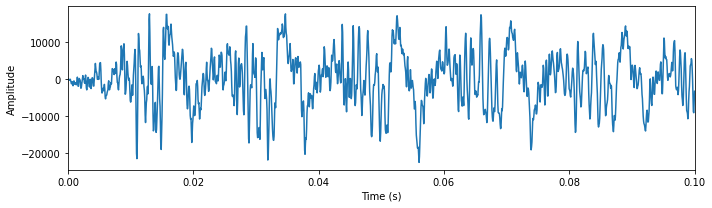

- original sound:


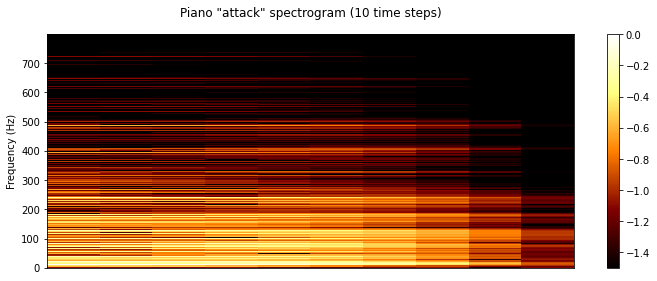

- reconstructed sound:


--------------
Piano sustain:
--------------


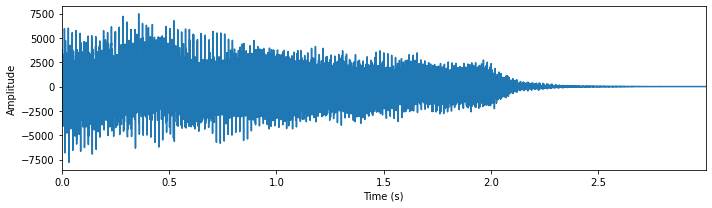

- original sound:


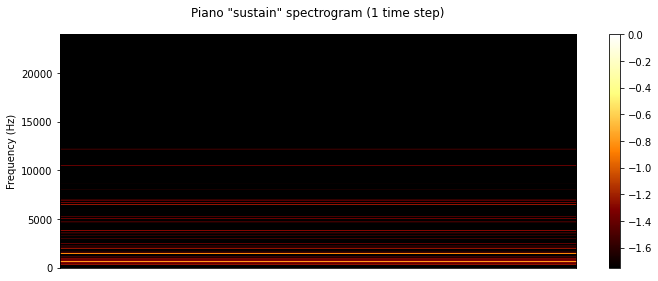

- reconstructed sound:


In [4]:
# Piano
params = [
    {'start': 0, 'end': 0.1, 'time_intervals': 10, 'spec_thresh': 3, 'max_freq': -1,
     'print': 'Piano attack:', 'title': 'Piano "attack" spectrogram (10 time steps)'},
    {'start': 1, 'end': -1, 'time_intervals': 1, 'spec_thresh': 3.5, 'max_freq': -1,
     'print': 'Piano sustain:', 'title': 'Piano "sustain" spectrogram (1 time step)'}
]
for p in params:
    # Print
    print('-' * len(p['print']))
    print(p['print'])
    print('-' * len(p['print']))
    # Load and play audio
    piano.load_audio(p['start'], p['end'])
    piano.plot_audio()
    print('- original sound:')
    piano.play_audio()
    # Create spectrogram and reconstruct audio
    piano.audio_to_spectrogram(p['time_intervals'], p['spec_thresh'])
    piano.plot_spectrogram(piano.spectrogram/2, max_freq=p['max_freq'],
                           title=p['title'], figsize=(10, 4))
    print('- reconstructed sound:')
    piano.spectrogram_to_audio(piano.spectrogram)

# Convolve spectrogram
# piano.convolve_spectrogram()
# piano.plot_spectrogram(piano.spectrogram_conv)
# piano.spectrogram_to_audio(piano.spectrogram_conv)

# 2. Post-filter analysis

After applying a lowpass filter which removes frequencies above the 2nd harmonic:

- The guitar sounds roughly the same (just a lowpass version)
- The piano sounds very different (almost like the guitar now)


This shows that:

- The guitar tone has a lot of energy in its lower harmonics
- The piano tone has a lot of energy in its upper harmonics

## Guitar

No filter:


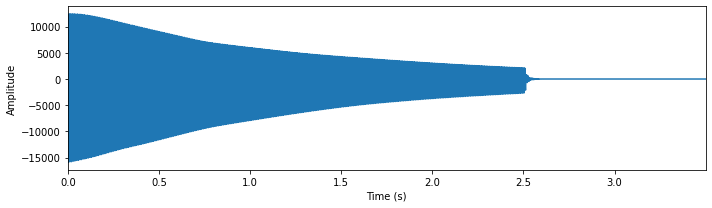

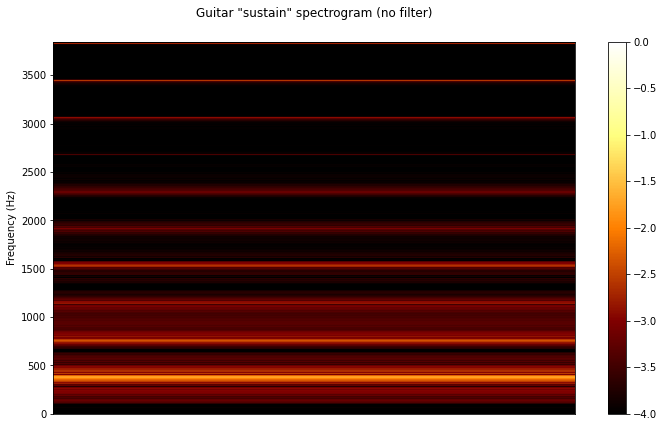

Low-pass filter:


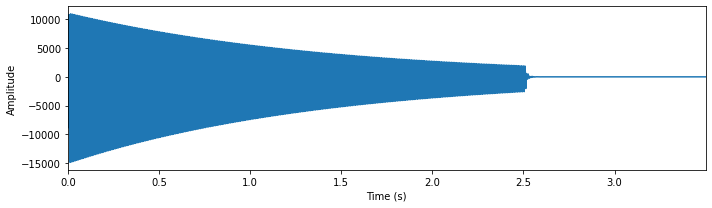

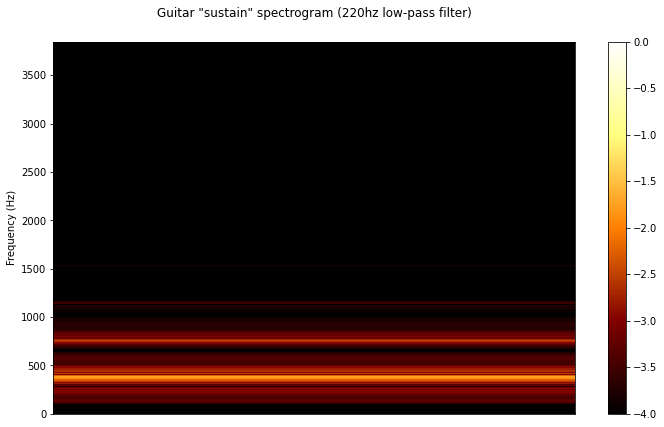

In [5]:
print('No filter:')
# Load and play audio
guitar.load_audio(start=0.5)
guitar.plot_audio()
guitar.play_audio()
# Create spectrogram
guitar.audio_to_spectrogram(spec_thresh=4)
guitar.plot_spectrogram(guitar.spectrogram, 'Guitar "sustain" spectrogram (no filter)')

print('Low-pass filter:')
# Load and play audio - with lowpass filter
guitar.load_audio(start=0.5, butter=(0, 220, 'lowpass'))
guitar.plot_audio()
guitar.play_audio()
# Create spectrogram
guitar.audio_to_spectrogram(spec_thresh=4)
guitar.plot_spectrogram(guitar.spectrogram, 'Guitar "sustain" spectrogram (220hz low-pass filter)')

## Piano

No filter


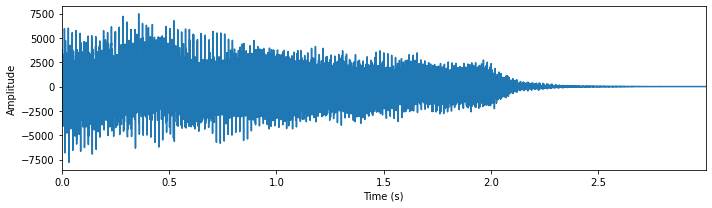

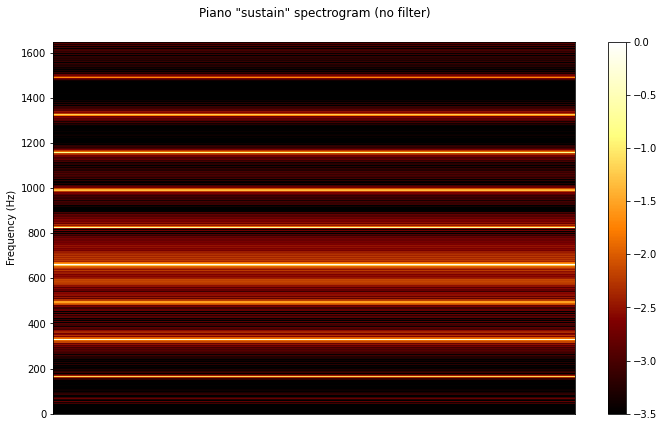

Low-pass filter:


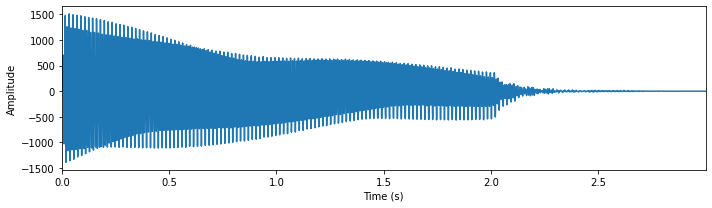

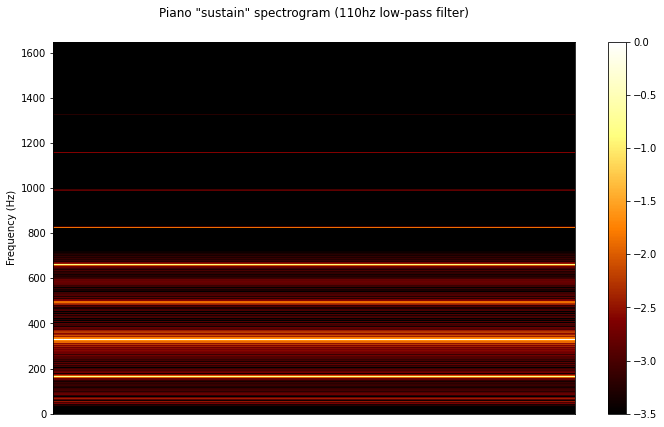

In [6]:
print('No filter')
# Load and play audio
piano.load_audio(start=1)
piano.plot_audio()
piano.play_audio()
# Create spectrogram
piano.audio_to_spectrogram(spec_thresh=3.5)
piano.plot_spectrogram(piano.spectrogram, 'Piano "sustain" spectrogram (no filter)')

print('Low-pass filter:')
# Load and play audio - with lowpass filter
piano.load_audio(start=1, butter=(0, 110, 'lowpass'))
piano.plot_audio()
piano.play_audio()
# Create spectrogram
piano.audio_to_spectrogram(spec_thresh=3.5)
piano.plot_spectrogram(piano.spectrogram, 'Piano "sustain" spectrogram (110hz low-pass filter)')

# 3. Harmonics analysis

Removing all frequencies except the harmonics of the fundamental frequency:

- The guitar sounds roughly the same (just a bit more like a pure sine-wave oscillator)
- The piano sounds very different (kind of like a chime or square wave)


This shows that:

- The guitar tone has a lot of energy in the harmonics themselves
- The piano tone has a lot of energy in the frequencies around its harmonics

N.B. Setting the same amplitude to all of the harmonics (0dB - maximum) sounds like a sawtooth wave. This demonstrates that the relative amplitudes of the harmonics has an important role in determining the final sound.

## Guitar

All frequencies:


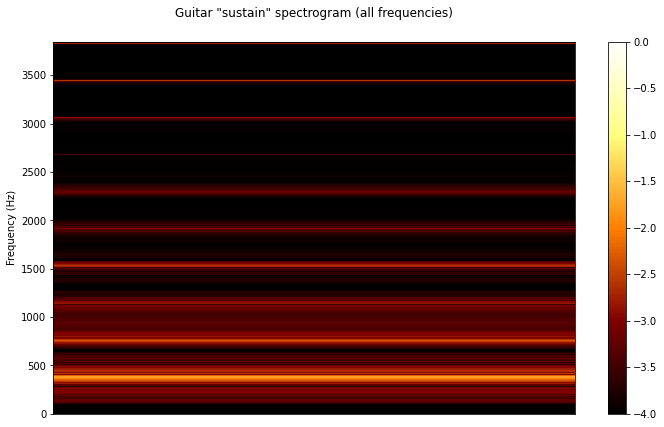

Harmonics only:


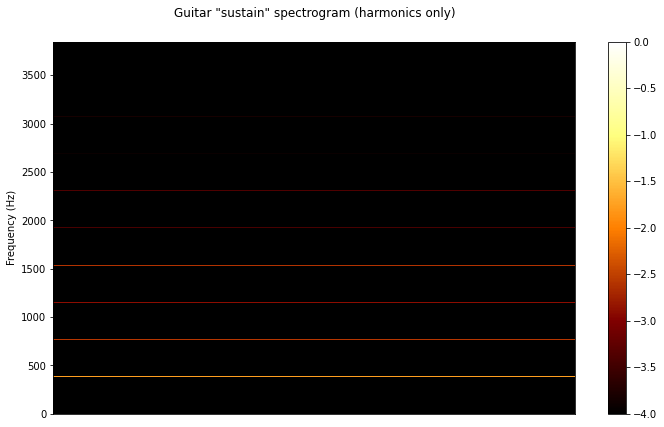

In [7]:
neighbour_radius = 4

print('All frequencies:')
# Load audio and create spectrogram
guitar.load_audio(start=0.5)
guitar.audio_to_spectrogram(spec_thresh=4)
guitar.plot_spectrogram(guitar.spectrogram, 'Guitar "sustain" spectrogram (all frequencies)')
guitar.spectrogram_to_audio(guitar.spectrogram)

print('Harmonics only:')
# Create spectrogram which only contains the harmonics
guitar.filter_harmonics(neighbour_radius)
guitar.plot_spectrogram(guitar.spectrogram_harm, 'Guitar "sustain" spectrogram (harmonics only)')
guitar.spectrogram_to_audio(guitar.spectrogram_harm)

## Piano

All frequencies:


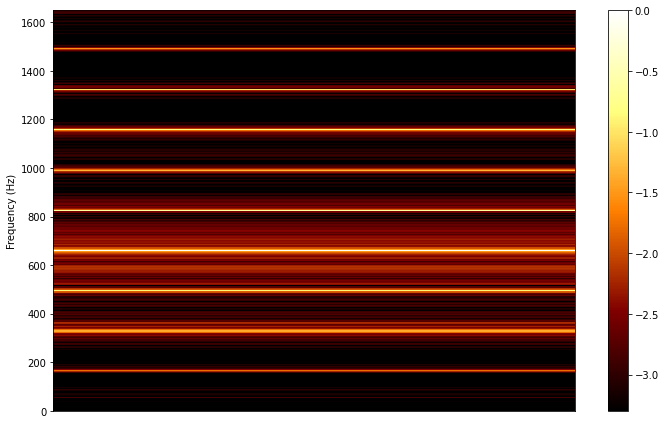

Harmonics only:


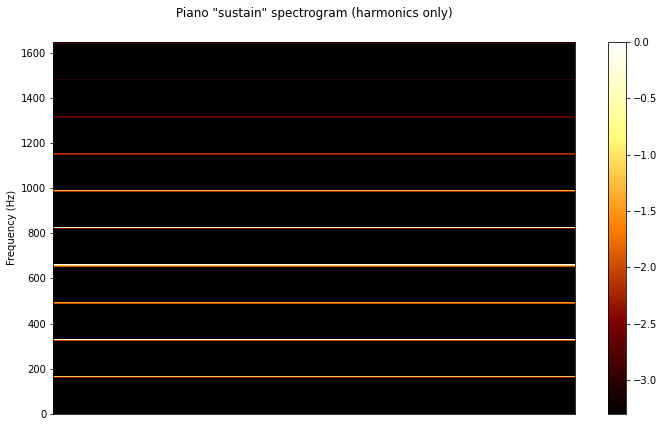

In [8]:
neighbour_radius = 4

print('All frequencies:')
# Load audio and create spectrogram
piano.load_audio(start=1)
piano.audio_to_spectrogram(spec_thresh=3.3)
piano.plot_spectrogram(piano.spectrogram)
piano.spectrogram_to_audio(piano.spectrogram, 'Piano "sustain" spectrogram (all frequencies)')

print('Harmonics only:')
# Create spectrogram which only contains the harmonics
piano.filter_harmonics(neighbour_radius)
piano.plot_spectrogram(piano.spectrogram_harm, 'Piano "sustain" spectrogram (harmonics only)')
piano.spectrogram_to_audio(piano.spectrogram_harm)

# 4. Log scale

## Guitar

Linear scale:


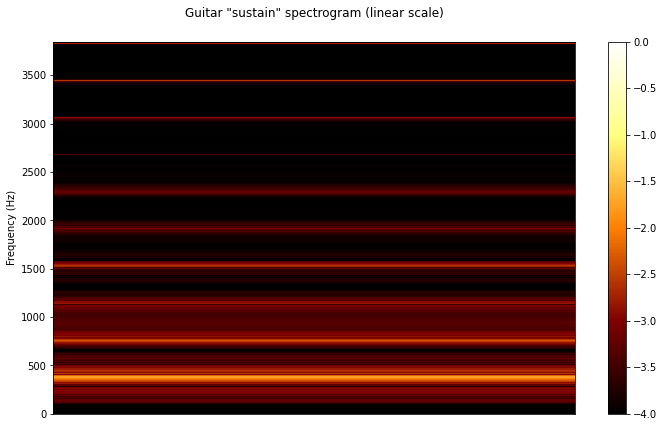

Log scale:


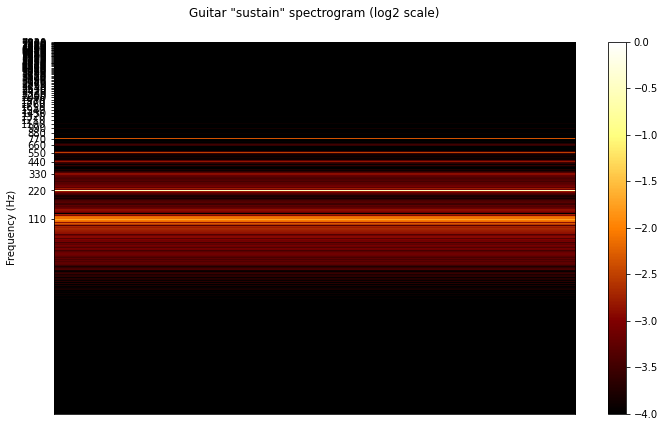

In [9]:
print('Linear scale:')
# Load audio and create spectrogram
guitar.load_audio(start=0.5)
guitar.audio_to_spectrogram(spec_thresh=4)
guitar.plot_spectrogram(guitar.spectrogram, 'Guitar "sustain" spectrogram (linear scale)')

print('Log scale:')
# Create spectrogram on log scale
guitar.spectrogram_to_log(guitar.spectrogram)
guitar.plot_spectrogram(guitar.spectrogram_log, 'Guitar "sustain" spectrogram (log2 scale)',
                        log_scale=True, max_freq=-1)

## Piano

Linear scale:


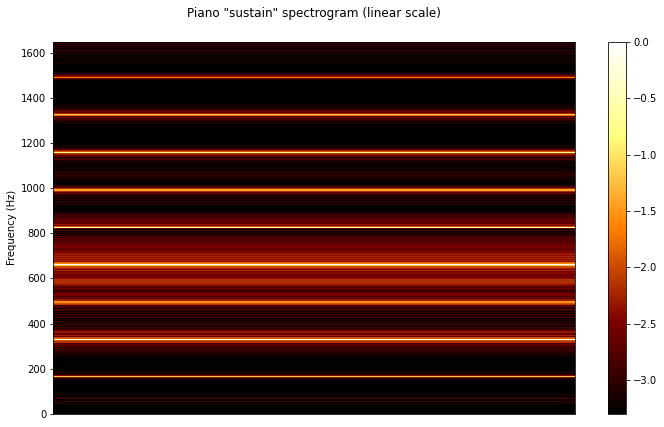

Log scale:


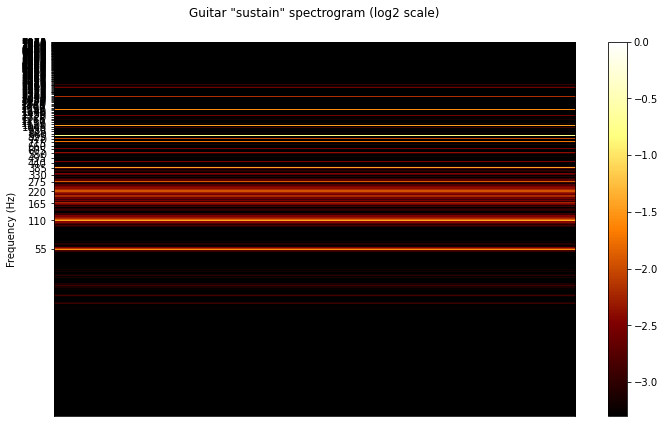

In [10]:
print('Linear scale:')
# Load audio and create spectrogram
piano.load_audio(start=1)
piano.audio_to_spectrogram(spec_thresh=3.3)
piano.plot_spectrogram(piano.spectrogram, 'Piano "sustain" spectrogram (linear scale)')

print('Log scale:')
# Create spectrogram on log scale
piano.spectrogram_to_log(piano.spectrogram)
piano.plot_spectrogram(piano.spectrogram_log, 'Guitar "sustain" spectrogram (log2 scale)',
                       log_scale=True, max_freq=-1)